In [117]:
import numpy as np

import scipy.sparse.linalg
from scipy import sparse

from lanczos import *

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

from IPython.display import clear_output

## Exercise 5: Lanczos algorithm

In [2]:
# a)

# system parameters
L = 14
print(f"Hilbert space dim: {2**L}")
g = 1.5
J = 1.0

# generate site-specific sigma_x and sigma_z lists
sx_list = gen_sx_list(L)
sz_list = gen_sz_list(L)

# generate the Hamiltonian
H = gen_hamiltonian(sx_list, sz_list, g, J)

# generate a random initial state vector
IC = np.random.rand(2**L)
IC = IC / np.linalg.norm(IC)  # Normalize the state vector

Hilbert space dim: 16384


In [4]:
# b.1)

# Lanczos iteration
T, vecs = lanczos(IC, H, N=200, stabilize=False)

# Calculate eigenvalues of the tridiagonal matrix T
eigenvalues = np.linalg.eigvalsh(T)

# Extract the 7 smallest eigenvalues
smallest_eigenvalues = np.sort(eigenvalues)[:7]

# Print the 7 smallest eigenvalues to examine them
print("Smallest Eigenvalues of T:", np.round(smallest_eigenvalues, 3))
print("true H 3 low energies:    ", np.round(sparse.linalg.eigsh(H, 7, which="SA")[0],3))

Smallest Eigenvalues of T: [-23.408 -23.408 -23.408 -22.406 -22.406 -22.406 -21.927]
true H 3 low energies:     [-23.408 -22.406 -21.927 -21.927 -21.126 -21.057 -21.057]


In [5]:
# b.2)

# stabilize=True reintroduces an explicit reorthogonalization step against all previous vectors in the Krylov space after each iteration

# Lanczos iteration
T, vecs = lanczos(IC, H, N=200, stabilize=True)

# Calculate eigenvalues of the tridiagonal matrix T
eigenvalues = np.linalg.eigvalsh(T)

# Extract the 7 smallest eigenvalues
smallest_eigenvalues = np.sort(eigenvalues)[:7]

# Print the 7 smallest eigenvalues to examine them
print("Smallest Eigenvalues of T:", np.round(smallest_eigenvalues, 3))
print("true H 3 low energies:    ", np.round(sparse.linalg.eigsh(H, 7, which="SA")[0],3))

Smallest Eigenvalues of T: [-23.408 -22.406 -21.927 -21.927 -21.126 -21.057 -21.057]
true H 3 low energies:     [-23.408 -22.406 -21.927 -21.927 -21.126 -21.057 -21.057]


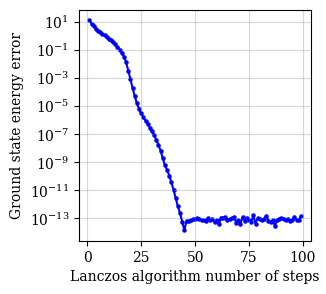

In [6]:
# add: ground state energy convergence
# Curious behavior observed
# Doesn't matter stabilize=True/False


def plot_lanczos_convergence(IC, ax, stabilize=False, N_max=100, color="blue"):
    n_steps = np.arange(1, N_max, 1);
    ground_state_energy_list = np.zeros(n_steps.shape[0]);
    ground_state_energy_true = sparse.linalg.eigsh(H, 7, which="SA")[0][0]
    
    for (i, j) in enumerate(n_steps):
        print(i)
        clear_output(wait=True)
        T, vecs = lanczos(IC, H, N=j, stabilize=False)
        ground_state_energy = np.linalg.eigvalsh(T)[0]
        ground_state_energy_list[i] = ground_state_energy
    
    ax.plot(n_steps, np.abs(ground_state_energy_list-ground_state_energy_true), color=color)
    ax.scatter(n_steps, np.abs(ground_state_energy_list-ground_state_energy_true), color=color, s=5)
    ax.set_yscale("log")
    ax.set_xlabel("Lanczos algorithm number of steps")
    ax.set_ylabel("Ground state energy error")
    ax.grid(alpha=0.5)


fig, ax = plt.subplots(figsize=(3,3))
plot_lanczos_convergence(IC, ax)
plt.show()

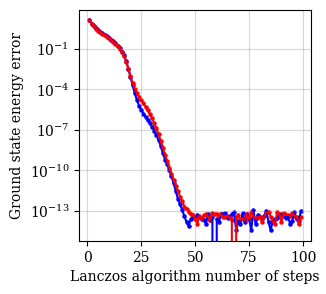

In [7]:
# d)

Splus_full = singlesite_to_full(Splus, 0, L)  # Expand S+ to the full space at site 0
phi0 = Splus_full.dot(IC)  # Apply S+ to the ground state psi0

fig, ax = plt.subplots(figsize=(3,3))
plot_lanczos_convergence(IC, ax, color="blue")
plot_lanczos_convergence(phi0, ax, color="red")
plt.show()

T_phi, vecs_phi = lanczos(phi0, H, N=200, stabilize=True)  # Using stabilize=True for numerical stability

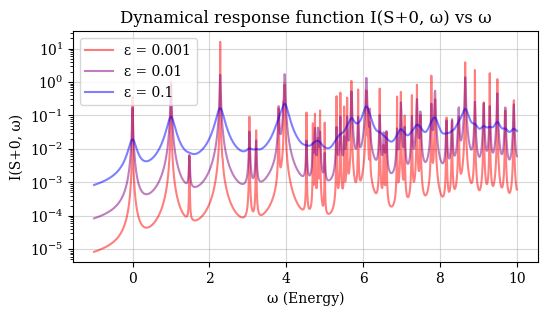

In [86]:
# e, f)


def calculate_x0(z, T):
    N = T.shape[0]
    alpha = np.diag(T)
    beta = np.diag(T, k=1)
    
    def continued_fraction(n, z):
        """ Recursive function to calculate the continued fraction """
        if n == N - 1:
            return 1 / (z - alpha[n])
        else:
            return 1 / (z - alpha[n] - beta[n]**2 * continued_fraction(n + 1, z))
    
    return -1/np.pi * np.imag(continued_fraction(0, z))

def plot_I_omega(T, E0, epsilon_values, omega_range, ax):
    """ Function to compute I(omega) for various epsilon """
    for (epsilon, color) in zip(epsilon_values, ("red", "purple", "blue")):
        x0_values = np.array([calculate_x0(omega + E0 + 1j * epsilon, T) for omega in omega_range])
        ax.plot(omega_range, x0_values, label=f'ε = {epsilon}', color=color, alpha=0.5)
    
    ax.set_title('Dynamical response function I(S+0, ω) vs ω')
    ax.set_xlabel('ω (Energy)')
    ax.set_ylabel('I(S+0, ω)')
    ax.grid(alpha=0.5)


# Parameters
omega_range = np.linspace(-1, 10, 1000)  # Example range for omega
epsilon_values = [0.001, 0.01, 0.1]  # Different values of epsilon for analysis
E0 = eigenvalues[0]  # Assuming eigenvalues from previous computations

# Execute the plotting function
fig, ax = plt.subplots(figsize=(6, 3))
plot_I_omega(T_phi, E0, epsilon_values, omega_range, ax)
ax.legend(loc="upper left")
ax.set_yscale("log")
plt.show()

# A smaller value of 𝜖 => sharper peaks

In [108]:
# g)

def calculate_Splus_k_sparse(k):
    """Calculate the momentum-dependent S+_k operator using sparse matrices"""
    Splus_k = sparse.csr_matrix((2**L, 2**L), dtype=complex)
    for j in range(L):
        phase = np.exp(1j * k * j * 2 * np.pi / L)
        Splus_j = singlesite_to_full(Splus, j, L)
        Splus_k += phase * Splus_j
    return Splus_k / np.sqrt(L)

def get_response_function(g, J, omega_shift=0.0, calculate_O_k=calculate_Splus_k_sparse):
    H = gen_hamiltonian(sx_list, sz_list, g, J)
    epsilon = 0.001 
    k_values = np.arange(L) 
    omega_range = np.linspace(-1, 10, 1000)+omega_shift
    response_function = np.zeros((len(k_values), len(omega_range)), dtype=np.float32)
    
    for idx, k in enumerate(k_values):
        O_k = calculate_O_k(k)
        phi0_k = O_k.dot(IC)
        T_k, _ = lanczos(phi0_k, H, N=200, stabilize=True)
        
        for jdx, omega in enumerate(omega_range):
            print(idx, jdx)
            clear_output(wait=True)
            z = omega + E0 + 1j * epsilon
            response_function[idx, jdx] = calculate_x0(z, T_k)
            
    return response_function

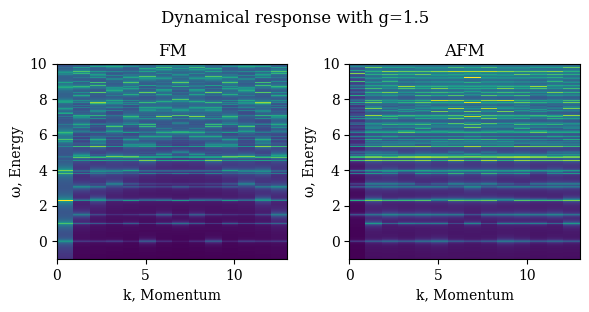

In [95]:
response_function_FM = get_response_function(g=1.5, J=1.0);
response_function_AFM = get_response_function(g=1.5, J=-1.0);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

ax1.imshow(np.log(1e-10+response_function_FM).T, aspect=1, origin='lower', extent=(0, 13, -1, 10), interpolation="nearest")
ax1.set_title('FM')
ax2.imshow(np.log(1e-10+response_function_AFM).T, aspect=1, origin='lower', extent=(0, 13, -1, 10), interpolation="nearest")
ax2.set_title('AFM')
for ax in (ax1, ax2):
    ax.set_ylabel('ω, Energy')
    ax.set_xlabel('k, Momentum')
plt.suptitle(f'Dynamical response with g={g}')
plt.tight_layout()
plt.show()

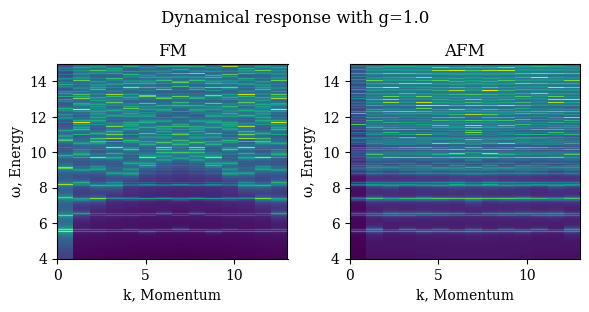

In [127]:
g = 1.0;
omega_shift = 5.0;
response_function_FM = get_response_function(g=g, J=1.0, omega_shift=omega_shift);
response_function_AFM = get_response_function(g=g, J=-1.0, omega_shift=omega_shift);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

ax1.imshow(np.log(1e-10+response_function_FM).T, aspect=1, origin='lower', extent=(0, 13, -1+omega_shift, 10+omega_shift), interpolation="nearest")
ax1.set_title('FM')
ax2.imshow(np.log(1e-10+response_function_AFM).T, aspect=1, origin='lower', extent=(0, 13, -1+omega_shift, 10+omega_shift), interpolation="nearest")
ax2.set_title('AFM')
for ax in (ax1, ax2):
    ax.set_ylabel('ω, Energy')
    ax.set_xlabel('k, Momentum')
plt.suptitle(f'Dynamical response with g={g}')
plt.tight_layout()
plt.show()

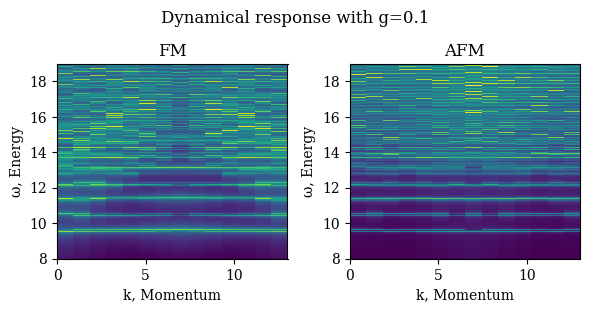

In [125]:
g = 0.1;
omega_shift = 9.0
response_function_FM = get_response_function(g=g, J=1.0, omega_shift=omega_shift);
response_function_AFM = get_response_function(g=g, J=-1.0, omega_shift=omega_shift);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

ax1.imshow(np.log(1e-10+response_function_FM).T, aspect=1, origin='lower', extent=(0, 13, -1+omega_shift, 10+omega_shift), interpolation="nearest")
ax1.set_title('FM')
ax2.imshow(np.log(1e-10+response_function_AFM).T, aspect=1, origin='lower', extent=(0, 13, -1+omega_shift, 10+omega_shift), interpolation="nearest")
ax2.set_title('AFM')
for ax in (ax1, ax2):
    ax.set_ylabel('ω, Energy')
    ax.set_xlabel('k, Momentum')
plt.suptitle(f'Dynamical response with g={g}')
plt.tight_layout()
plt.show()

### bonus

In [118]:
def get_ck_dagger(k, L=L):
    ck_dagger = sparse.csr_matrix((2**L, 2**L), dtype=complex)
    for j in range(L):
        phase_factor = np.exp(-1j * k * j * 2 * np.pi / L)
        temp_operator = Splus
        for m in range(j):
            temp_operator = sparse.kron(Sz, temp_operator)
        for m in range(j + 1, L):
            temp_operator = sparse.kron(temp_operator, Id)
        ck_dagger += phase_factor * temp_operator
    return ck_dagger / np.sqrt(L)

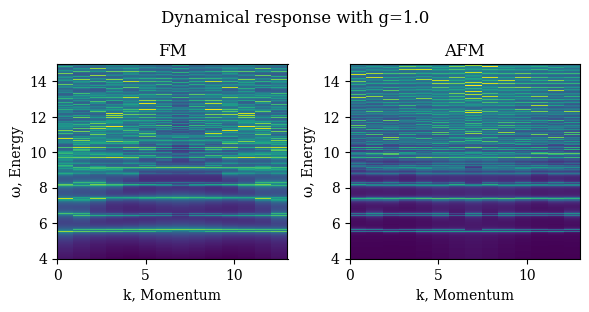

In [123]:
g = 1.0;
omega_shift = 5.0;
response_function_FM = get_response_function(g=g, J=1.0, omega_shift=omega_shift, calculate_O_k=get_ck_dagger);
response_function_AFM = get_response_function(g=g, J=-1.0, omega_shift=omega_shift, calculate_O_k=get_ck_dagger);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

ax1.imshow(np.log(1e-10+response_function_FM).T, aspect=1, origin='lower', extent=(0, 13, -1+omega_shift, 10+omega_shift), interpolation="nearest")
ax1.set_title('FM')
ax2.imshow(np.log(1e-10+response_function_AFM).T, aspect=1, origin='lower', extent=(0, 13, -1+omega_shift, 10+omega_shift), interpolation="nearest")
ax2.set_title('AFM')
for ax in (ax1, ax2):
    ax.set_ylabel('ω, Energy')
    ax.set_xlabel('k, Momentum')
plt.suptitle(f'Dynamical response with g={g}')
plt.tight_layout()
plt.show()

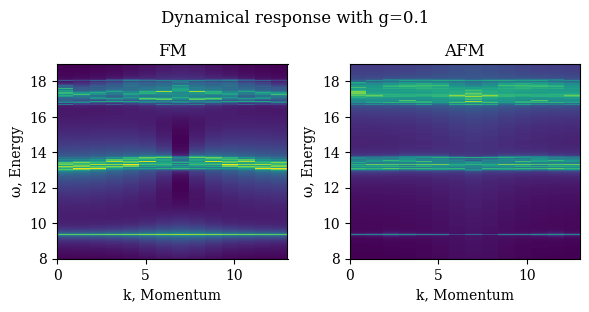

In [120]:
g = 0.1;
omega_shift = 9.0;
response_function_FM = get_response_function(g=g, J=1.0, omega_shift=omega_shift, calculate_O_k=get_ck_dagger);
response_function_AFM = get_response_function(g=g, J=-1.0, omega_shift=omega_shift, calculate_O_k=get_ck_dagger);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

ax1.imshow(np.log(1e-10+response_function_FM).T, aspect=1, origin='lower', extent=(0, 13, -1+omega_shift, 10+omega_shift), interpolation="nearest")
ax1.set_title('FM')
ax2.imshow(np.log(1e-10+response_function_AFM).T, aspect=1, origin='lower', extent=(0, 13, -1+omega_shift, 10+omega_shift), interpolation="nearest")
ax2.set_title('AFM')
for ax in (ax1, ax2):
    ax.set_ylabel('ω, Energy')
    ax.set_xlabel('k, Momentum')
plt.suptitle(f'Dynamical response with g={g}')
plt.tight_layout()
plt.show()

# what is nice, because for g~0 eigenstates are states with determined k